In [1]:
matplotlib inline


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


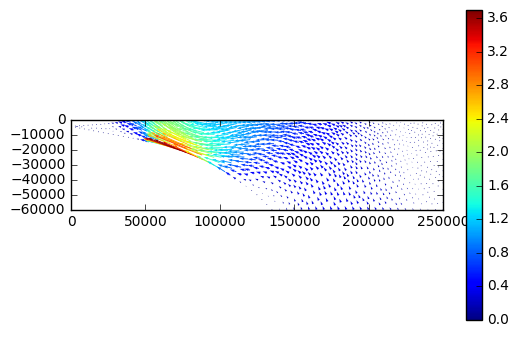

In [2]:
# %load elastic_2d.py
"""
FEniCS program for the elastic response to a megathrust earthquake on the overlying continental crust. This is the forward elastic problem given synthetic slip on the bottom boundary.

Kimberly McCormack
08/20/15

3D
"""

from dolfin import *
import numpy as np
import time
import openpyxl as pyxl
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
import shutil, os
import scipy.io
import scipy.interpolate
dolfin.parameters.reorder_dofs_serial = False
import scipy as sp
from scipy.interpolate import griddata
from tempfile import TemporaryFile

"""


"""
start = time.time()

##########################################################################
########################### USER INPUTS ##################################
##########################################################################

plot_figs = 'yes' # Plot figures with fenics plotter?
event = 'syn' # syn = synthetic event, data = real EQ data
new_mesh = 'yes' # Creates new indices file to extract solution at surface nodes/GPS stations when turned on, otherwise it loads a previously saved file. Must = 'yes' at least once to create files. TURN OFF ONLY IF NONE OF THE FOLLOWING HAVE BEEN CHANGED: a) mesh file  b) mesh refinement 3) order of basis functions
drained = 'undrained' #drained or undrained

#################### SYNTHETIC EVENT PARAMETERS #########################

sigma_b = 2e4 # Std deviation from the center of slip(loosely, how big is the area of slip?)
xcenter = 80e3 # How far is the center of the slip patch from the trench?
u0_EQ = -4.0 # For an EQ, what was the max slip?

######################## SOLVER ##########################################

solver = LUSolver('petsc')


##########################################################################
################### DEFINE MESH AND PARAMETERS ###########################
##########################################################################
#Change the path name for the mesh files!

path = "/home/fenics/shared/meshes"

mesh = Mesh(path+"/CR2D.xml")
boundaries = MeshFunction("size_t", mesh,path+"/CR2D_facet_region.xml")

V = VectorFunctionSpace(mesh,'Lagrange', 1)
u = TrialFunction(V)
v = TestFunction(V)

ds = Measure('ds', domain=mesh, subdomain_data=boundaries)
n = FacetNormal(mesh) #normal vector

######################## ELASTIC PARAMETERS #############################


nu = .4 # undrained poissons ratio
delta = 1e-6
#E = Constant('5e4') # Young's modulus [MPa]
E = Expression('(5.7972e-10*(-(pow(x[1],3)))) - (7.25283e-5*(-(pow(x[1],2)))) + (3.8486e-6*(-x[1])) + 6.94e4', degree=2) # Young's modulus [MPa]. Fit from Deshon paper
mu   = Expression('E / (2.0*(1.0 + nu))', E=E, nu=nu, degree=2) # shear modulus
lmbda = Expression('E*nu / ((1.0 + nu)*(1.0 - 2.0*nu))', E=E, nu=nu, degree=2)  # Lame's parameter
d = u.geometric_dimension() # number of space dimensions
I = Identity(d)
T = (I - outer(n,n)) # tangent operator for boundary condition


##########################################################################
################### INITIAL AND BOUNDARY CONDITIONS ######################
##########################################################################

#Initial conditions: (('p0','ux0','uy0'))

################### DIRICHLET BOUNDARY CONDITIONS ########################

ub0 = Expression(('0','0'), degree=1)
ub = Expression(('-1','1'), degree=1)
bc1 = DirichletBC(V, ub, boundaries, 1) #ocean
bc2 = DirichletBC(V, ub0, boundaries, 2) #surface
bc3 = DirichletBC(V, ub0, boundaries, 3) # slab
bc4 = DirichletBC(V, ub0, boundaries, 4) # back(no slip condition)
bc5 = DirichletBC(V, ub0, boundaries, 5) # mantle (no slip condition)

bcs = [bc4] #These are the BC's that are actually applied
slab = 3 # Boundary number of the subducting slab

############### INITIAL BOUNDARY CONDITION ##############################
u0d = u0_EQ
u0slab = Expression(('u0d*exp(-(pow((x[0] - xcenter),2)/(pow(sigma,2))))', '0'), u0d=u0d, xcenter=xcenter,sigma=sigma_b, degree=1)


##########################################################################
############################ ASSEMBLE SYSTEM #############################
##########################################################################

def strain(w): # strain = 1/2 (grad u + grad u^T)
    return sym(nabla_grad(w))
def sigma(w): # stress = 2 mu strain + lambda tr(strain) I
    return 2.0*mu*strain(w) + lmbda*div(w)*I

a_E = assemble(inner(sigma(u),nabla_grad(v))*dx) #Elasticity
a_Boundary = assemble((1/delta)*dot(u,n)*dot(v,n)*ds(slab) + (1/delta)*inner(T*u ,T*v)*ds(slab)) #Weakly imposed boundary conditions. First term: no displacement normal to the bottom boundary, Second term: tangential displacement  = u0slab

A = a_E + a_Boundary # Left hand side (LHS)

a_Boundary0 = assemble((1/delta)*inner(T*u0slab ,T*v)*ds(slab))

b = Vector()
b = a_Boundary0
[bc.apply(b) for bc in bcs]
[bc.apply(A) for bc in bcs]
u = Function(V)
solver.set_operator(A)
solver.solve(u.vector(), b)


#f = Expression("0", degree=2)
#g = Expression("0", degree=2)
#a = inner(grad(u), grad(v))*dx
#L = f*v*dx + g*v*ds

# Compute solution
#u = Function(V)
#solve(a == L, u, bcs)


fig = plt.figure()
contour = plot(u, interactive=True)
fig.colorbar(contour)





In [3]:
from IPython.display import HTML


In [6]:
HTML(X3DOM().html(p))

TypeError: in method 'X3DOM_html', argument 1 of type 'dolfin::Function const &'